In [1]:
import pandas as pd
import math
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# === Load CSV ===
file_path = "Test.csv"   # change to your CSV file
df = pd.read_csv(file_path)

print("✅ CSV Loaded:")
print(df.head())


✅ CSV Loaded:
                Name
0           AARTHI S
1          ABIRAMI E
2            AGNES A
3        Ajaykumar R
4  AKSHAY ANIL KUMAR


In [2]:
# Number of rows in dataset
num_rows = len(df)

# Number of qubits needed to represent rows
num_qubits = math.ceil(math.log2(num_rows))

print(f"Rows: {num_rows}, Qubits required: {num_qubits}")


Rows: 183, Qubits required: 8


In [3]:
# Assign row indices and convert to binary strings
df["RowIndex"] = df.index
df["BinaryIndex"] = df["RowIndex"].apply(
    lambda x: format(x, f"0{num_qubits}b")
)

print("✅ Dataset with binary mapping:")
print(df.head())


✅ Dataset with binary mapping:
                Name  RowIndex BinaryIndex
0           AARTHI S         0    00000000
1          ABIRAMI E         1    00000001
2            AGNES A         2    00000010
3        Ajaykumar R         3    00000011
4  AKSHAY ANIL KUMAR         4    00000100


In [4]:
# Map {binary index → row data}
mapping = {
    row["BinaryIndex"]: row.to_dict()
    for _, row in df.iterrows()
}

print("✅ Binary-to-row mapping created")


✅ Binary-to-row mapping created


In [5]:
search_column = "Name"       # choose column
search_value = "PRIYANKA R"        # user input

target_rows = df[df[search_column] == search_value]

if target_rows.empty:
    print(f"❌ No match found for {search_value} in column {search_column}")
    target_binary = None
else:
    target_row = target_rows.iloc[0]
    target_binary = target_row["BinaryIndex"]

    print("✅ Match found:")
    print(target_row.to_dict())
    print(f"Target binary index: {target_binary}")


✅ Match found:
{'Name': 'PRIYANKA R', 'RowIndex': 119, 'BinaryIndex': '01110111'}
Target binary index: 01110111


Oracle Boolean expression: q0 & q1 & q2 & ~q3 & q4 & q5 & q6 & ~q7


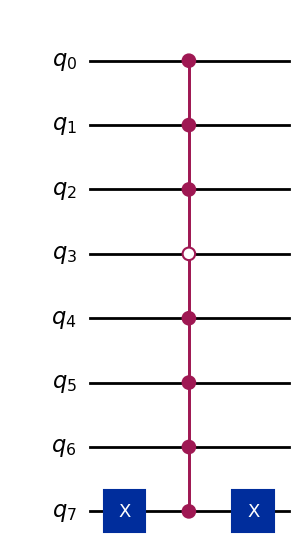

In [6]:
from qiskit.circuit.library import PhaseOracle

# Build a Boolean expression from the target binary
def binary_to_expr(target_binary):
    expr_terms = []
    for i, bit in enumerate(target_binary[::-1]):  # reverse order (q0 = least significant)
        if bit == "1":
            expr_terms.append(f"q{i}")
        else:
            expr_terms.append(f"~q{i}")
    return " & ".join(expr_terms)

if target_binary is None:
    raise ValueError("❌ No valid target found in Cell 5.")

expr = binary_to_expr(target_binary)
print("Oracle Boolean expression:", expr)

oracle = PhaseOracle(expr)
oracle.draw("mpl")


In [7]:
def build_diffuser(n):
    qc = QuantumCircuit(n)
    
    qc.h(range(n))
    qc.x(range(n))
    
    mcx = MCXGate(n - 1)
    qc.append(mcx, list(range(n)))
    
    qc.x(range(n))
    qc.h(range(n))
    
    return qc


In [8]:
if target_binary is None:
    raise ValueError("❌ No valid target found. Please check your input in Cell 5.")

oracle = build_oracle(target_binary)
diffuser = build_diffuser(num_qubits)

grover = QuantumCircuit(num_qubits, num_qubits)

# Initialize in superposition
grover.h(range(num_qubits))

# Grover iterations
iterations = round(math.pi/4 * math.sqrt(2**num_qubits))
print(f"Running Grover with {iterations} iterations")

for _ in range(iterations):
    grover.append(oracle, range(num_qubits))
    grover.append(diffuser, range(num_qubits))

grover.measure(range(num_qubits), range(num_qubits))
grover.draw("mpl")


NameError: name 'build_oracle' is not defined

Result counts: {'10111000': 1, '11010011': 1, '10000000': 2, '10101101': 1, '00101000': 1, '10011111': 2, '10110011': 1, '00100010': 3, '11000001': 1, '01101001': 3, '00001000': 2, '10101111': 1, '00001011': 2, '10011101': 3, '01010101': 2, '01110110': 2, '11010010': 1, '01011010': 4, '11011011': 1, '00000010': 4, '00010101': 3, '11111000': 4, '00100011': 4, '01101000': 8, '11100011': 3, '11111010': 1, '11000000': 3, '10001011': 1, '10100011': 3, '11100000': 2, '11110110': 1, '10010100': 3, '11011110': 2, '00110010': 3, '00111100': 3, '01100010': 5, '01010001': 3, '01101100': 3, '01001101': 2, '10011100': 1, '11100001': 3, '01100110': 5, '10011110': 2, '10110110': 2, '10000101': 2, '00111000': 2, '11101100': 2, '00101111': 5, '01101011': 1, '01100000': 4, '11001111': 2, '00110000': 5, '11100110': 4, '10000100': 3, '10110111': 2, '00111110': 1, '00100000': 2, '11011010': 1, '10111010': 1, '10001001': 2, '00000011': 2, '01001100': 3, '00100101': 5, '10111011': 4, '11111011': 1, '11000100

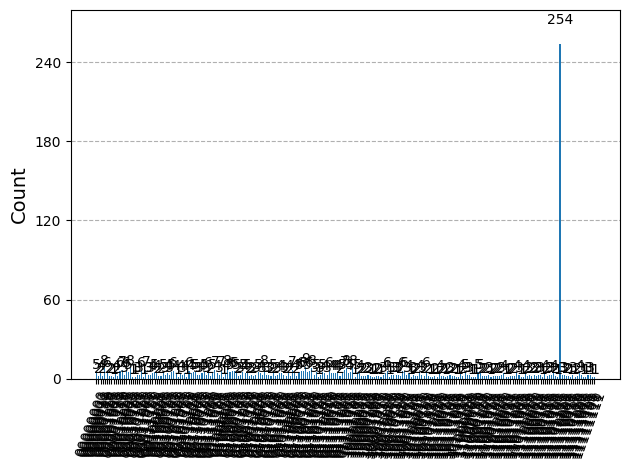

In [ ]:
sim = Aer.get_backend("qasm_simulator")
compiled = transpile(grover, sim)
result = sim.run(compiled, shots=1024).result()

counts = result.get_counts()
print("Result counts:", counts)

plot_histogram(counts)


In [ ]:
most_common_binary = max(counts, key=counts.get)
print(f"Most frequent measured binary index: {most_common_binary}")

row_data = mapping.get(most_common_binary, None)

if row_data:
    print("✅ Corresponding row found in CSV:")
    print(row_data)
else:
    print("❌ No matching row found in mapping.")


Most frequent measured binary index: 11101110
❌ No matching row found in mapping.
